In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

import os
import glob
import re
import pandas as pd
from scanf import scanf
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf

# %matplotlib notebook

rc('animation', html='html5')
fontsize = 40
figsize = (30, 16)
PWD = os.getcwd()

In [2]:
def read_data_loopup_table(psi_dir_list, tcenter, ignore_first=0):
    ecoli_U_list = []
    ecoli_norm_list = []
    ecoli_center_list = []
    ecoli_nodes_list = []
    ecoli_lateral_norm_list = []
    ecoli_idx_list = []
    norm_phi_list = []
    norm_psi_list = []
    norm_theta_list = []
    i0 = -1
    t1 = []
    for psi_dir in psi_dir_list:
        file_handle = os.path.basename(psi_dir)
        mat_names = natsort.natsorted(glob.glob('%s/%s_*.mat' % (psi_dir, file_handle)))
        for mati in mat_names[ignore_first:]:
            i0 = i0 + 1
            mat_contents = loadmat(mati)
            ecoli_U = mat_contents['ecoli_U'].flatten()
            ecoli_norm = mat_contents['ecoli_norm'].flatten()
            ecoli_center = mat_contents['ecoli_center'].flatten()
            planeShearRate = mat_contents['planeShearRate'].flatten()
            ecoli_nodes = mat_contents['ecoli_nodes']
            norm_phi = mat_contents['norm_phi'].flatten()
            norm_psi = mat_contents['norm_psi'].flatten()
            norm_theta = mat_contents['norm_theta'].flatten()
            ecoli_U_list.append(ecoli_U)
            ecoli_norm_list.append(ecoli_norm)
            ecoli_center_list.append(ecoli_center)
            ecoli_idx_list.append(i0)
            norm_phi_list.append(norm_phi)
            norm_psi_list.append(norm_psi)
            norm_theta_list.append(norm_theta)
            r0 = ecoli_nodes[-1] - ecoli_center
            n0 = np.dot(r0, ecoli_norm) * ecoli_norm / np.dot(ecoli_norm, ecoli_norm)
            t0 = r0 - n0
            ecoli_lateral_norm_list.append(t0 / np.linalg.norm(t0))

    ecoli_U = np.vstack(ecoli_U_list)
    ecoli_norm = np.vstack(ecoli_norm_list)
    ecoli_center = np.vstack(ecoli_center_list)
    ecoli_lateral_norm = np.vstack(ecoli_lateral_norm_list)
    ecoli_idx = np.hstack(ecoli_idx_list)
    norm_phi = np.hstack(norm_phi_list)
    norm_psi = np.hstack(norm_psi_list)
    norm_theta = np.hstack(norm_theta_list)
    norm_tpp = np.vstack((norm_theta, norm_phi, norm_psi)).T

    # calculate velocity u000(t,x,y,z) that the location initially at (0, 0, 0): u000(0, 0, 0, 0)
    n_u000 = -np.linalg.norm(ecoli_center[0] - tcenter) * ecoli_norm
    ecoli_u000 = ecoli_U[:, :3] + np.cross(ecoli_U[:, 3:], n_u000)
    # calculate center center000(t,x,y,z) that at initially at (0, 0, 0): center000(0, 0, 0, 0)
    ecoli_center000 = ecoli_center + n_u000
    using_U = ecoli_U
    omega_norm = np.array([np.dot(t1, t2)*t2/np.dot(t2, t2) for t1, t2 in zip(using_U[:, 3:], ecoli_norm)])
    omega_tang = using_U[:, 3:] - omega_norm
    
    return ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, ecoli_idx, norm_tpp, \
           ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate

In [4]:
# interpolate on grid 
importlib.reload(spf)
job_dir = 'hlxB01_tau1a'

t_dir = os.path.join(PWD, job_dir)
psi_dir_list = natsort.natsorted([os.path.join(t_dir, o) for o in os.listdir(t_dir) 
                                  if os.path.isdir(os.path.join(t_dir, o))])
tcenter = np.zeros(3)
ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, ecoli_idx, norm_tpp, \
  ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate \
  = read_data_loopup_table(psi_dir_list=psi_dir_list, tcenter=tcenter, ignore_first=0)

norm_theta = norm_tpp[:, 0]
norm_phi = norm_tpp[:, 1]
norm_psi = norm_tpp[:, 2]
data = pd.DataFrame({'norm_theta': norm_theta, 
                    'norm_phi': norm_phi, 
                    'norm_psi': norm_psi, 
                    'ecoli_idx': ecoli_idx, 
                    }).pivot_table(index=['norm_theta', 'norm_phi', 'norm_psi'])
norm_tpp = np.vstack(data.index.get_values())
norm_theta = norm_tpp[:, 0]
norm_phi = norm_tpp[:, 1]
norm_psi = norm_tpp[:, 2]
use_theta = np.unique(norm_theta)
use_phi = np.unique(norm_phi)
use_psi = np.unique(norm_psi)
n_theat, n_phi, n_psi = use_theta.size, use_phi.size, use_psi.size
ecoli_idx2 = ecoli_idx.reshape(n_theat, n_phi, n_psi)

savemat(job_dir,
        {'use_theta':    use_theta,
         'use_phi': use_phi,
         'use_psi': use_psi,
         'ecoli_idx': ecoli_idx2,
         'ecoli_norm': ecoli_norm,
         'ecoli_U': ecoli_U,
         'ecoli_u000': ecoli_u000,
         'omega_norm': omega_norm,
         'omega_tang': omega_tang,
         'planeShearRate': planeShearRate,
         'tcenter': tcenter, },
         oned_as='column')


In [6]:
filename = job_dir
mat_contents = loadmat(filename)
use_theta = mat_contents['use_theta'].flatten()
use_phi = mat_contents['use_phi'].flatten()
use_psi = mat_contents['use_psi'].flatten()
n_theat, n_phi, n_psi = use_theta.size, use_phi.size, use_psi.size
ecoli_idx = mat_contents['ecoli_idx']
ecoli_U = [tu.reshape(n_theat, n_phi, n_psi) for tu in mat_contents['ecoli_U'].T]

ecoli_U_intp = interpolate.RegularGridInterpolator((use_theta, use_phi, use_psi), ecoli_U[0])
t_theta = np.random.sample(1) * np.pi / 2
t_phi = np.random.sample(1) * np.pi
t_psi = np.random.sample(1) * np.pi
ecoli_U_intp((t_theta, t_phi, t_psi))


array([ 0.00441])

In [8]:
# interpolate using RBF 
importlib.reload(spf)
job_dir = 'hlxB01_tau1a'
epsilon = 0.1

def intp_norm(x1, x2):
#     t1 = x1 - x2
    t1 = (x1 - x2 + np.pi) % (2 * np.pi) - np.pi
    norm = np.sqrt(((t1)**2).sum(axis=0))
    return norm

t_dir = os.path.join(PWD, job_dir)
psi_dir_list = natsort.natsorted([os.path.join(t_dir, o) for o in os.listdir(t_dir) 
                                  if os.path.isdir(os.path.join(t_dir, o))])
tcenter = np.zeros(3)
ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, ecoli_idx, norm_tpp, \
  ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate \
  = read_data_loopup_table(psi_dir_list=psi_dir_list, tcenter=tcenter, ignore_first=0)

norm_theta = norm_tpp[:, 0]
norm_phi = norm_tpp[:, 1]
norm_psi = norm_tpp[:, 2]
data = pd.DataFrame({'norm_theta': norm_theta, 
                    'norm_phi': norm_phi, 
                    'norm_psi': norm_psi, 
                    'ecoli_idx': ecoli_idx, 
                    }).pivot_table(index=['norm_theta', 'norm_phi', 'norm_psi'])
norm_tpp = np.vstack(data.index.get_values())
ref_U_idx = data.values.flatten()
ref_U_list = ecoli_U[ref_U_idx]
ref_U_intp_list = []
for ui in ref_U_list.T:
    ref_U_intp = interpolate.Rbf(norm_tpp[:, 0], norm_tpp[:, 1], norm_tpp[:, 2], ui, norm=intp_norm, function='gaussian', epsilon=epsilon)
    ref_U_intp_list.append(ref_U_intp)


In [9]:
t_theta = np.random.sample(1) * np.pi / 2
t_phi = np.random.sample(1) * np.pi
# t_psi = np.random.sample(1) * 2 * np.pi
t_psi = np.zeros(1)
t_ref_U = []
for ref_U_intp in ref_U_intp_list:
    t_ref_U.append(ref_U_intp(t_theta, t_phi, t_psi))
print('  -norm_theta %f  -norm_phi %f  -norm_psi %f' % (t_theta, t_phi, t_psi))
print(np.hstack(t_ref_U))


  -norm_theta 1.457265  -norm_phi 3.065609  -norm_psi 0.000000
[-0.00667  0.00971 -0.00578 -0.05818  0.16545 -0.01795]


In [7]:
# interpolate using spline, 2d+1d
import datetime

importlib.reload(spf)
job_dir = 'hlxB01_tau1a'
print(datetime.datetime.now())

def intp_norm(x1, x2):
#     t1 = x1 - x2
    t1 = (x1 - x2 + np.pi) % (2 * np.pi) - np.pi
    norm = np.sqrt(((t1)**2).sum(axis=0))
    return norm

t_dir = os.path.join(PWD, job_dir)
psi_dir_list = natsort.natsorted([os.path.join(t_dir, o) for o in os.listdir(t_dir) 
                                  if os.path.isdir(os.path.join(t_dir, o))])
tcenter = np.zeros(3)
ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, ecoli_idx, norm_tpp, \
  ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate \
  = read_data_loopup_table(psi_dir_list=psi_dir_list, tcenter=tcenter, ignore_first=0)

2019-03-22 19:47:22.184223


In [27]:
norm_theta = norm_tpp[:, 0]
norm_phi = norm_tpp[:, 1]
norm_psi = norm_tpp[:, 2]
epsilon = np.pi / 50
data = pd.DataFrame({'norm_theta': norm_theta, 
                    'norm_phi': norm_phi, 
                    'norm_psi': norm_psi, 
                    'ecoli_U0': ecoli_U[:, 0], 
                    'ecoli_U1': ecoli_U[:, 1], 
                    'ecoli_U2': ecoli_U[:, 2], 
                    'ecoli_U3': ecoli_U[:, 3], 
                    'ecoli_U4': ecoli_U[:, 4], 
                    'ecoli_U5': ecoli_U[:, 5], 
                    }).pivot_table(index=['norm_theta', 'norm_phi', 'norm_psi'])

ecoli_U0 = data.ecoli_U0.unstack()
ecoli_U1 = data.ecoli_U1.unstack()
ecoli_U2 = data.ecoli_U2.unstack()
ecoli_U3 = data.ecoli_U3.unstack()
ecoli_U4 = data.ecoli_U4.unstack()
ecoli_U5 = data.ecoli_U5.unstack()
use_theta_list = data.index.levels[0].values
use_phi_list = data.index.levels[1].values
use_psi_list = data.index.levels[2].values

table_data = []
intp_fun_list = []
for tpsi in use_psi_list: # interpolate over 1d, psi
    tintp_fun_list = []
    table_psi_data = []
#     # show phase map
#     fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5)] = plt.subplots(nrows=3, ncols=2, figsize=(60, 45))
#     fig.patch.set_facecolor('white')
#     axs = (ax0, ax1, ax2, ax3, ax4, ax5) 
#     for t1, axi in zip(data.columns.values, axs): # interpolate fun for [ux,uy,uz,wx,wy,wz]
    for t1 in data.columns.values: # interpolate fun for [ux,uy,uz,wx,wy,wz]
        tu = data[t1].unstack()
        tU = tu[tpsi].unstack()
        tx = tU.columns.values
        ty = tU.index.values
        # interpolate over 2d
        tfun = interpolate.RectBivariateSpline(ty, tx, tU)
        tintp_fun_list.append(tfun)
        table_psi_data.append((ty, tx, tU))
    table_data.append((tpsi, table_psi_data))
    intp_fun_list.append(tintp_fun_list)




In [9]:
import pickle
filename = job_dir
with open('%s.pickle' % filename, 'wb') as handle:
    pickle.dump(table_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('%s.pickle' % filename, 'rb') as handle:
    table_data = pickle.load(handle)

intp_fun_list = []
for tpsi, table_psi_data in table_data:
    tintp_fun_list = []
    for ty, tx, tU in table_psi_data:
        tfun = interpolate.RectBivariateSpline(ty, tx, tU)
        tintp_fun_list.append(tfun)
    intp_fun_list.append(tintp_fun_list)


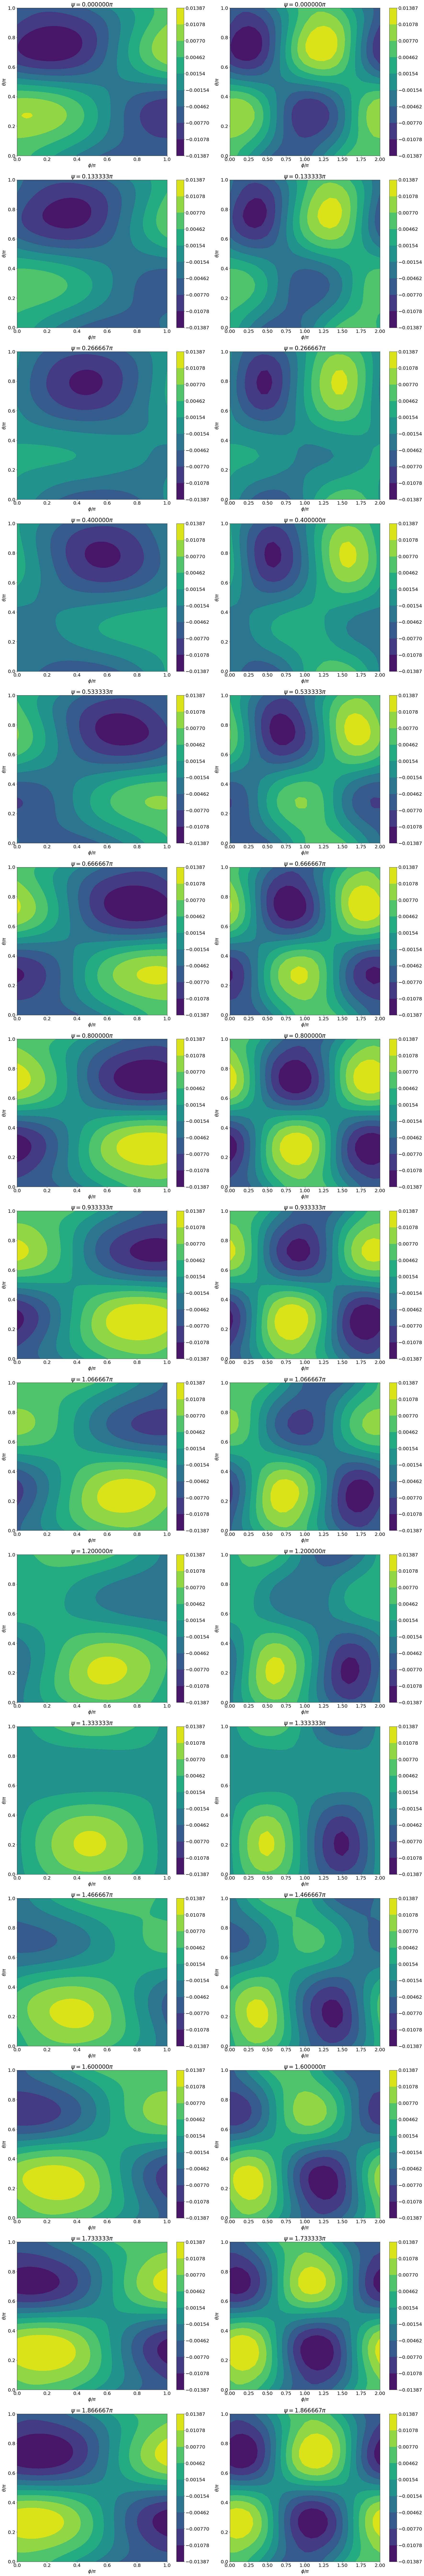

In [32]:
def intp_U_fun(t_theta, t_phi, t_psi):
    if 0 <= t_theta <= np.pi and 0 <= t_phi < np.pi:  # letf down
        sign_list = [1, 1, 1, 1, 1, 1]
    elif 0 <= t_theta <= np.pi and np.pi <= t_phi <= 2 * np.pi:  # right down
        t_theta = t_theta
        t_phi = t_phi - np.pi
        sign_list = [1, 1, -1, 1, 1, -1]
    else:
        raise Exception('norm_theta %f and (or) norm_phi %f out of range (0, pi) * (0, 2pi)' % (t_theta, t_phi))

    intp_U = []
    for tfun in intp_fun_list:
        t_U = []
        for intp_fun, sign in zip(tfun, sign_list):
            t_U.append(intp_fun(t_theta, t_phi) * sign)
        intp_U.append(np.hstack(t_U).flatten())
    intp_U.append(intp_U[0].copy())
    intp_U = np.vstack(intp_U)
    intp_psi = np.hstack([use_psi_list, np.pi * 2])
    intp_fun1d = interpolate.interp1d(intp_psi, intp_U, kind='quadratic', axis=0, fill_value='extrapolate')
    return intp_fun1d(t_psi)


fig = plt.figure(figsize=(25, 150))
fig.patch.set_facecolor('white')
axs = fig.subplots(nrows=15, ncols=2)
t_use_U, t_use_Uidx = ecoli_U2, 2
t1 = np.nanmax(np.abs(t_use_U.values))
for tpsi, (ax0, ax1) in zip(use_psi_list, axs):
    use_U = t_use_U[tpsi].unstack()
    levels = np.linspace(-t1, t1, 10)
    im = ax0.contourf(use_phi_list / np.pi, use_theta_list / np.pi, use_U.values, levels)
    ax0.set_title('$\\psi=%f \pi$' % (tpsi / np.pi))
    ax0.set_xlabel('$\\phi / \pi$')
    ax0.set_ylabel('$\\theta / \pi$')
    fig.colorbar(im, ax=ax0, orientation='vertical')

    txx, tyy = np.meshgrid(np.linspace(0, np.pi, 25), np.linspace(0, 2*np.pi, 25))
    tU = txx.copy().flatten()
    for i0, (tx1, ty1) in enumerate(zip(txx.flatten(), tyy.flatten())):
        tU[i0] = intp_U_fun(tx1, ty1, tpsi)[t_use_Uidx]
    im = ax1.contourf(tyy / np.pi, txx / np.pi, tU.reshape(txx.shape), levels)
    ax1.set_title('$\\psi=%f \pi$' % (tpsi / np.pi))
    ax1.set_xlabel('$\\phi / \pi$')
    ax1.set_ylabel('$\\theta / \pi$')
    fig.colorbar(im, ax=ax1, orientation='vertical')
    plt.tight_layout()


In [11]:
test_angs = np.random.sample(3)
intp_U = intp_U_fun(test_angs[0], test_angs[1], test_angs[2])
print(test_angs)
print(intp_U)
print('mpirun -n 24 python ../../../loop_table_helix.py  -f dbg  -pickProblem 0  -save_singleEcoli_vtk 0  -rh1 0.300000  -rh2 0.100000  -ch 3.000000  -nth 20  -eh -1.000000  -ph 0.666667  -hfct 1.000000  -n_tail 1  -with_cover 2  -left_hand 0  -rs1 1.500000  -rs2 0.500000  -ds 0.070000  -es -1.000000  -with_T_geo 0  -dist_hs 0.500000  -ksp_max_it 300  -plot_geo 0  -rel_wsz 0.000000  -rel_whz100.000000  -ffweight 2.000000  -sm pf  -zoom_factor 1.000000  -planeShearRatex 1.000000 -test_location 1 -norm_theta %f  -norm_phi %f  -norm_psi %f' % 
      (test_angs[0], test_angs[1], test_angs[2]))

[ 0.46923  0.1057   0.79254]
[-0.0014  -0.01805  0.00179  0.01072  0.76567 -0.01895]
mpirun -n 24 python ../../../loop_table_helix.py  -f dbg  -pickProblem 0  -save_singleEcoli_vtk 0  -rh1 0.300000  -rh2 0.100000  -ch 3.000000  -nth 20  -eh -1.000000  -ph 0.666667  -hfct 1.000000  -n_tail 1  -with_cover 2  -left_hand 0  -rs1 1.500000  -rs2 0.500000  -ds 0.070000  -es -1.000000  -with_T_geo 0  -dist_hs 0.500000  -ksp_max_it 300  -plot_geo 0  -rel_wsz 0.000000  -rel_whz100.000000  -ffweight 2.000000  -sm pf  -zoom_factor 1.000000  -planeShearRatex 1.000000 -test_location 1 -norm_theta 0.469228  -norm_phi 0.105697  -norm_psi 0.792542


In [12]:
test_angs = np.random.sample(3) * (np.pi / 2, 2 * np.pi, np.pi * 2)
test_angs2 = test_angs.copy()
# test_angs2[1] = test_angs2[1] if test_angs2[1] < np.pi else 2 * np.pi - test_angs2[1]
test_angs2[1] = -test_angs2[1]
print(test_angs)
print('mpirun -n 24 python ../../../loop_table_helix.py  -f dbg  -pickProblem 0  -save_singleEcoli_vtk 0  -rh1 0.300000  -rh2 0.100000  -ch 3.000000  -nth 20  -eh -1.000000  -ph 0.666667  -hfct 1.000000  -n_tail 1  -with_cover 2  -left_hand 0  -rs1 1.500000  -rs2 0.500000  -ds 0.070000  -es -1.000000  -with_T_geo 0  -dist_hs 0.500000  -ksp_max_it 300  -plot_geo 0  -rel_wsz 0.000000  -rel_whz100.000000  -ffweight 2.000000  -sm pf  -zoom_factor 1.000000  -planeShearRatex 1.000000 -test_location_noIter 1 -norm_theta %f  -norm_phi %f  -norm_psi %f' % 
      (test_angs[0], test_angs[1], test_angs[2]))
print()
print(test_angs2)
print('mpirun -n 24 python ../../../loop_table_helix.py  -f dbg  -pickProblem 0  -save_singleEcoli_vtk 0  -rh1 0.300000  -rh2 0.100000  -ch 3.000000  -nth 20  -eh -1.000000  -ph 0.666667  -hfct 1.000000  -n_tail 1  -with_cover 2  -left_hand 0  -rs1 1.500000  -rs2 0.500000  -ds 0.070000  -es -1.000000  -with_T_geo 0  -dist_hs 0.500000  -ksp_max_it 300  -plot_geo 0  -rel_wsz 0.000000  -rel_whz100.000000  -ffweight 2.000000  -sm pf  -zoom_factor 1.000000  -planeShearRatex 1.000000 -test_location_noIter 1 -norm_theta %f  -norm_phi %f  -norm_psi %f' % 
      (test_angs2[0], test_angs2[1], test_angs2[2]))
print()

[ 1.41519  3.43184  6.12453]
mpirun -n 24 python ../../../loop_table_helix.py  -f dbg  -pickProblem 0  -save_singleEcoli_vtk 0  -rh1 0.300000  -rh2 0.100000  -ch 3.000000  -nth 20  -eh -1.000000  -ph 0.666667  -hfct 1.000000  -n_tail 1  -with_cover 2  -left_hand 0  -rs1 1.500000  -rs2 0.500000  -ds 0.070000  -es -1.000000  -with_T_geo 0  -dist_hs 0.500000  -ksp_max_it 300  -plot_geo 0  -rel_wsz 0.000000  -rel_whz100.000000  -ffweight 2.000000  -sm pf  -zoom_factor 1.000000  -planeShearRatex 1.000000 -test_location_noIter 1 -norm_theta 1.415189  -norm_phi 3.431842  -norm_psi 6.124526

[ 1.41519 -3.43184  6.12453]
mpirun -n 24 python ../../../loop_table_helix.py  -f dbg  -pickProblem 0  -save_singleEcoli_vtk 0  -rh1 0.300000  -rh2 0.100000  -ch 3.000000  -nth 20  -eh -1.000000  -ph 0.666667  -hfct 1.000000  -n_tail 1  -with_cover 2  -left_hand 0  -rs1 1.500000  -rs2 0.500000  -ds 0.070000  -es -1.000000  -with_T_geo 0  -dist_hs 0.500000  -ksp_max_it 300  -plot_geo 0  -rel_wsz 0.000000  -

In [16]:
5 % 3

2